In [17]:
# Interpretable_Depression_Diagnosis_ML.ipynb
# Project: Interpretable Depression Diagnosis from Brain Imaging (ML Lab)

# Required libraries
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [18]:
# Define 20 brain biomarkers (based on common depression-related brain regions)
feature_names = [
    'Prefrontal_Cortex_Connectivity', 'Hippocampus_Volume', 'Amygdala_Activation',
    'Subgenual_Cingulate_Connectivity', 'Default_Mode_Network_Strength',
    'Salience_Network_Integration', 'Frontal_Lobe_Thickness', 'Limbic_System_Correlation',
    'Thalamus_Connectivity', 'Insula_Response', 'Ventral_Striatum_Activity',
    'Orbitofrontal_Cortex', 'Temporal_Lobe_Connectivity', 'Parietal_Lobe_Integration',
    'Cerebellum_Volume', 'Brainstem_Signal', 'Corpus_Callosum_Thickness',
    'Ventricular_Enlargement', 'White_Matter_Integrity', 'Gray_Matter_Density'
]

# Generating synthetic MRI-based data (1000 samples, 20 features)
X, y = make_classification(
    n_samples=1000, n_features=20, n_informative=15, n_redundant=5,
    n_classes=2, weights=[0.6, 0.4], random_state=42
)

# DataFrame creation
df = pd.DataFrame(X, columns=feature_names)
df['Depression'] = y  # Target variable

# Save to CSV
df.to_csv('synthetic_depression_mri_data.csv', index=False)

print(df.head())
print(f"Dataset shape: {df.shape}")
print(f"Class distribution: {np.bincount(y)}")  # ~600 healthy, 400 depressed


   Prefrontal_Cortex_Connectivity  Hippocampus_Volume  Amygdala_Activation  \
0                       -4.906442            3.442789             0.558964   
1                        2.162610           -5.286651             2.609846   
2                       -6.678971           -0.854743            -2.214812   
3                       10.465024            1.070944            -3.562432   
4                        5.599516           -1.776412            -1.304322   

   Subgenual_Cingulate_Connectivity  Default_Mode_Network_Strength  \
0                         -0.976764                      -1.568805   
1                         -1.803898                      -1.831216   
2                         -0.529275                       2.562596   
3                         -0.849062                       2.183860   
4                         -0.720074                       5.859373   

   Salience_Network_Integration  Frontal_Lobe_Thickness  \
0                     -4.271982               -3.72

In [19]:
# Separate features and target
X = df.drop('Depression', axis=1)
y = df['Depression']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Feature selection using mutual information (top 10 biomarkers)
selector = SelectKBest(mutual_info_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Display selected biomarkers
selected_features = [feature_names[i] for i in selector.get_support(indices=True)]
print("Selected biomarkers:", selected_features)


Train shape: (800, 20), Test shape: (200, 20)
Selected biomarkers: ['Prefrontal_Cortex_Connectivity', 'Hippocampus_Volume', 'Amygdala_Activation', 'Default_Mode_Network_Strength', 'Frontal_Lobe_Thickness', 'Orbitofrontal_Cortex', 'Temporal_Lobe_Connectivity', 'Parietal_Lobe_Integration', 'Brainstem_Signal', 'Ventricular_Enlargement']


In [20]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_selected, y_train)
y_pred_lr = lr_model.predict(X_test_selected)

# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train_selected, y_train)
y_pred_dt = dt_model.predict(X_test_selected)

# Linear SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_selected, y_train)
y_pred_svm = svm_model.predict(X_test_selected)

# Evaluate all models
def evaluate_model(name, model, X_test, y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"{name}: Accuracy = {acc:.2f}, AUC = {auc:.2f}")
    return acc, auc

acc_lr, auc_lr = evaluate_model("Logistic Regression", lr_model, X_test_selected, y_test, y_pred_lr)
acc_dt, auc_dt = evaluate_model("Decision Tree", dt_model, X_test_selected, y_test, y_pred_dt)
acc_svm, auc_svm = evaluate_model("Linear SVM", svm_model, X_test_selected, y_test, y_pred_svm)


Logistic Regression: Accuracy = 0.79, AUC = 0.87
Decision Tree: Accuracy = 0.79, AUC = 0.83
Linear SVM: Accuracy = 0.79, AUC = 0.87


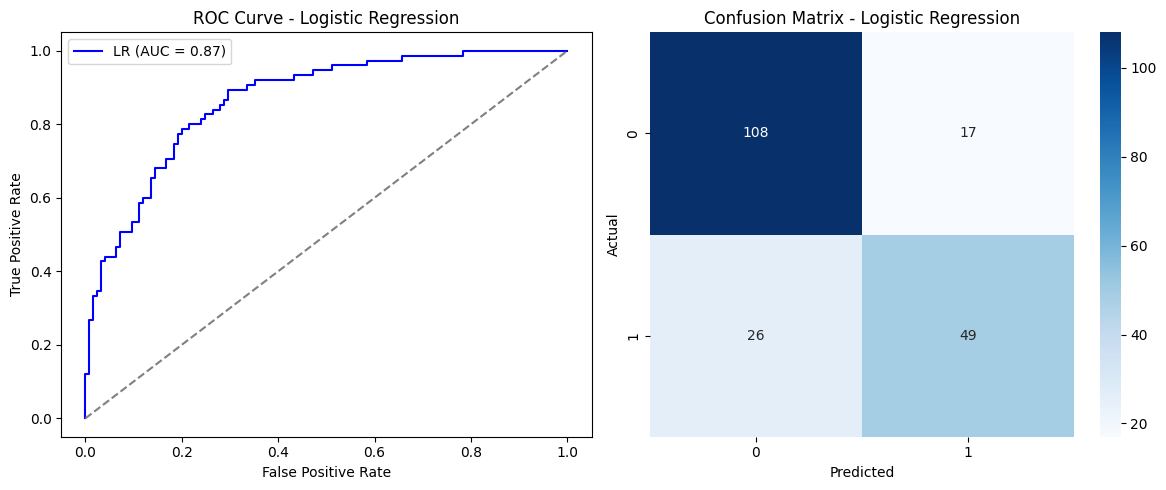

In [21]:
# Combined ROC Curve + Confusion Matrix for Logistic Regression
fpr, tpr, _ = roc_curve(y_test, lr_model.predict_proba(X_test_selected)[:, 1])
cm = confusion_matrix(y_test, y_pred_lr)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# ROC
ax[0].plot(fpr, tpr, label=f'LR (AUC = {auc_lr:.2f})', color='blue')
ax[0].plot([0,1], [0,1], '--', color='gray')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend()
ax[0].set_title('ROC Curve - Logistic Regression')

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')
ax[1].set_title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()



Top Contributing Biomarkers:
                        Biomarker  Coefficient  Absolute_Importance    Effect
6      Temporal_Lobe_Connectivity    -1.081330             1.081330  Negative
2             Amygdala_Activation     0.854277             0.854277  Positive
1              Hippocampus_Volume    -0.580399             0.580399  Negative
9         Ventricular_Enlargement    -0.529521             0.529521  Negative
5            Orbitofrontal_Cortex    -0.496845             0.496845  Negative
7       Parietal_Lobe_Integration    -0.386407             0.386407  Negative
4          Frontal_Lobe_Thickness     0.383263             0.383263  Positive
8                Brainstem_Signal     0.308332             0.308332  Positive
3   Default_Mode_Network_Strength    -0.194803             0.194803  Negative
0  Prefrontal_Cortex_Connectivity    -0.017478             0.017478  Negative


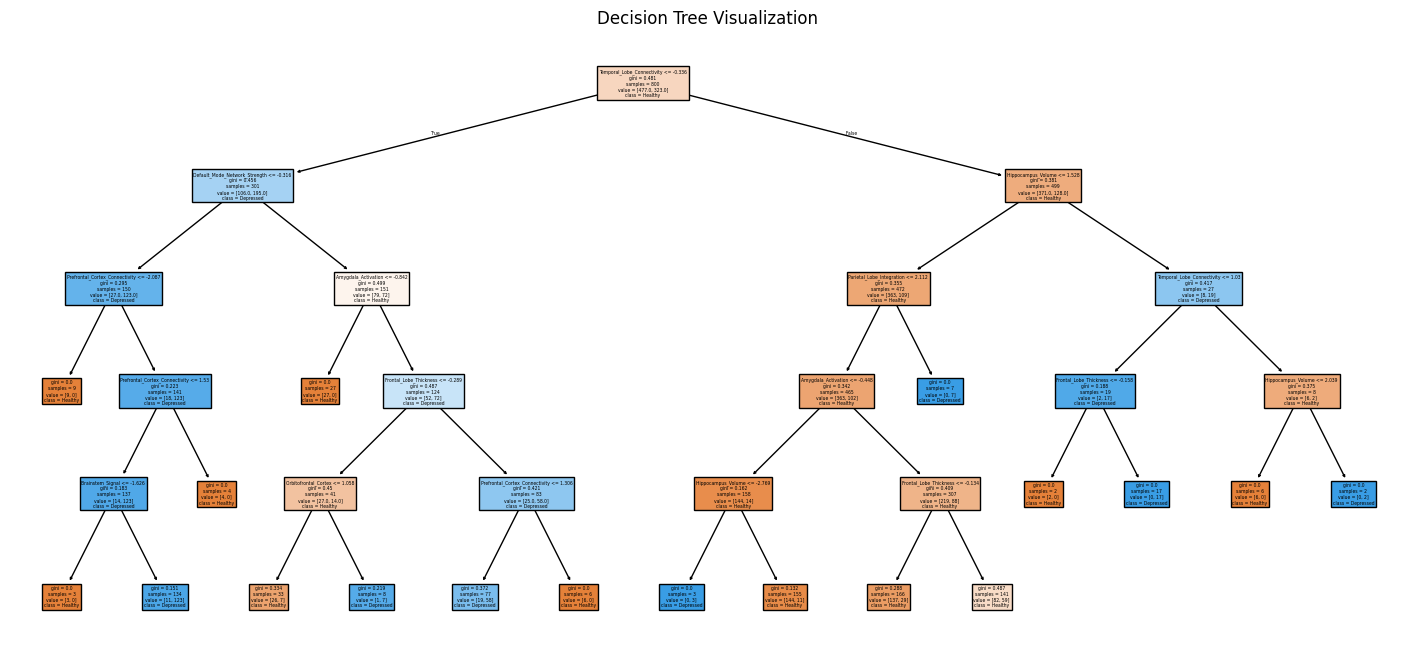

In [22]:
# Interpret LR coefficients (positive vs negative biomarkers)
coefficients = lr_model.coef_[0]
importance_df = pd.DataFrame({
    'Biomarker': selected_features,
    'Coefficient': coefficients,
    'Absolute_Importance': np.abs(coefficients),
    'Effect': ['Positive' if c > 0 else 'Negative' for c in coefficients]
}).sort_values('Absolute_Importance', ascending=False)

print("\nTop Contributing Biomarkers:")
print(importance_df)

# Visualize Decision Tree (rule-based interpretability)
plt.figure(figsize=(18, 8))
plot_tree(dt_model, feature_names=selected_features, class_names=['Healthy', 'Depressed'], filled=True)
plt.title('Decision Tree Visualization')
plt.show()


In [23]:
# 5-fold cross-validation (AUC-based)
cv_scores = cross_val_score(lr_model, X_train_selected, y_train, cv=5, scoring='roc_auc')
print(f"Logistic Regression (5-fold CV): Mean AUC = {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")


Logistic Regression (5-fold CV): Mean AUC = 0.82 ± 0.01
